In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.dates
import matplotlib.cm
import datetime

plt.style.use('dark_background')


In [2]:
filename = "/Users/baart_f/data/drought/lobith/AfvoerenLobith.xlsx"

In [3]:
df = pd.read_excel(filename, sheet_name='Lobith')

In [4]:
lobith_df = df.melt(
    id_vars=('maand', 'dag'), 
    value_vars=range(1901, 2024), 
    value_name='discharge', 
    var_name='year'
)

In [5]:
lobith_df = lobith_df.dropna(subset=['discharge'])
lobith_df['t'] = lobith_df.apply(
    lambda row: pd.Timestamp(year=row['year'], month=row['maand'], day=row['dag']),
    axis=1
)
lobith_df['t2000'] = lobith_df.apply(
    lambda row: pd.Timestamp(year=2000, month=row['maand'], day=row['dag']),
    axis=1
)

lobith_df['doy'] = lobith_df['t'].dt.dayofyear

In [6]:
annual_min_df = lobith_df.groupby('year').min()[['t', 'discharge']]

In [7]:
annual_min_df = annual_min_df[annual_min_df.index < 2023]

In [8]:
annual_min_df.sort_values('discharge').head(n=10)

,t,discharge
year,,
1929,1929-01-01,575.0
1947,1947-01-01,620.0
1949,1949-01-01,635.0
1963,1963-01-01,665.0
1921,1921-01-01,670.0
2022,2022-01-01,679.0
1954,1954-01-01,680.0
1953,1953-01-01,685.0
1959,1959-01-01,715.0


Text(0.5, 0, 'Dag van jaar')

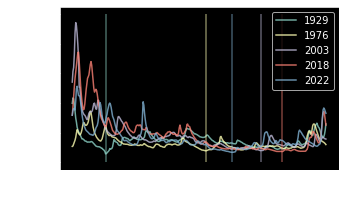

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

colors = [x["color"] for x in matplotlib.rcParams['axes.prop_cycle']]
years = [1929, 1976, 2003, 2018, 2022]
for color, year in zip(colors, years):
    selected = lobith_df[lobith_df['year'] == year]
    ax.plot(selected['t2000'], selected['discharge'], label=year, color=color, alpha=0.8)
    min_row = selected.loc[selected['discharge'].idxmin()]
    ax.vlines(min_row['t2000'], 0, 10000, alpha=0.5, color=color)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))    
ax.legend(loc='best')
ax.set_ylabel('Lobith afvoer [m3/s]')
ax.set_xlabel('Dag van jaar')


In [10]:
fig.tight_layout()
fig
fig.savefig('/Users/baart_f/src/drought-scrolly/example/drought-scrolly/images/figures/lobith.png')

Text(0.5, 0, 'Day of year')

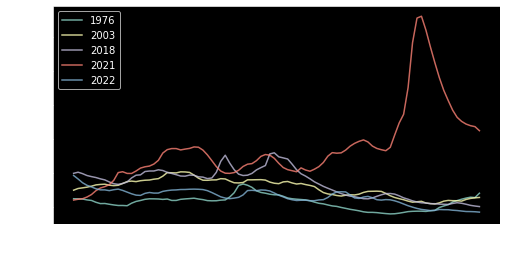

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

grouped = lobith_df[
    np.logical_and(
        lobith_df['year'] > (2022 - 30),
        np.isin(lobith_df['maand'], [5, 6, 7])
    )
].groupby('year')
for _, df_i in grouped:
    ax.plot(df_i['t2000'], df_i['discharge'], color=(0, 0, 0, 0.2))
    

colors = [x["color"] for x in matplotlib.rcParams['axes.prop_cycle']]
years = [1976, 2003, 2018, 2021, 2022]
for color, year in zip(colors, years):
    selected = lobith_df[lobith_df['year'] == year]
    selected = selected[np.isin(selected['maand'], [5, 6, 7])]
    ax.plot(selected['t2000'], selected['discharge'], label=year, color=color, alpha=0.8)
    min_row = selected.loc[selected['discharge'].idxmin()]
    # ax.vlines(min_row['t2000'], 0, 10000, alpha=0.5, color=color)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))    
ax.legend(loc='best')
ax.set_ylabel('Lobith discharge [m3/s]')
ax.set_xlabel('Day of year')


<Axes: xlabel='t'>

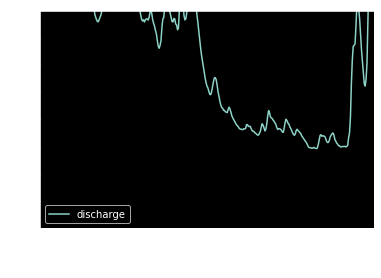

In [12]:
lobith_df[lobith_df['maand'].isin([10, 11, 12, 1, 2, 3])].groupby('year').min()[['t', 'discharge']]

lobith_df.query('year == 2018').plot('t', 'discharge', ylim=(0, 2000))

In [13]:
winter_min_df = lobith_df[lobith_df['maand'].isin([10, 11, 12, 1, 2, 3])].groupby('year').min()[['t', 'discharge']]
summer_min_df = lobith_df[lobith_df['maand'].isin([4, 5, 6, 7, 8, 9])].groupby('year').min()[['t', 'discharge']]

winter_min_df = winter_min_df[winter_min_df['t'] < datetime.datetime(2022, 10, 1)].reset_index()
summer_min_df = summer_min_df[summer_min_df['t'] < datetime.datetime(2023, 1, 1)].reset_index()
             
winter_min_df['season'] = 'winter'
summer_min_df['season'] = 'summer'
season_min_df = pd.concat([winter_min_df, summer_min_df])

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(13.835, 0.5, 'Lowest seasonal discharge $[m^3/s]$')

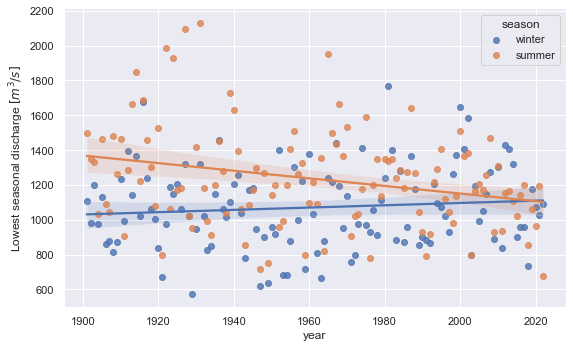

In [14]:
import seaborn as sns

sns.set(rc={"figure.figsize":(8, 3)})

grid = sns.lmplot(
    x="year",
    y="discharge",
    hue="season",
    data=season_min_df,
    lowess=False,
    aspect=1.6,
    legend_out=False
)

grid.ax.set_ylabel('Lowest seasonal discharge $[m^3/s]$')


In [15]:
filename = "/Users/baart_f/data/drought/lobith/era5m-rhine-history.geojson"
rhine_gdf = gpd.read_file(filename)

In [16]:
rhine_gdf['date'] = rhine_gdf['t'].apply(lambda x: datetime.datetime.fromtimestamp(x['value'] / 1000))

In [17]:
rhine_gdf['year'] = rhine_gdf['date'].apply(lambda x: x.year)

rhine_df = rhine_gdf[['year', 'snow_depth']]

In [18]:
merged_df = pd.merge(summer_min_df, rhine_df, left_on='year', right_on='year')

Text(0.5, 0, 'Snow depth water equivalent [m]')

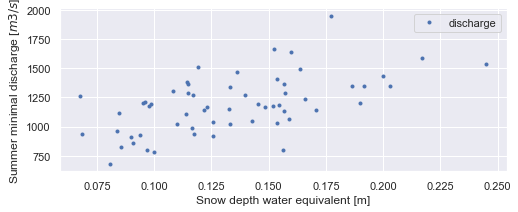

In [19]:
fig, ax = plt.subplots()
merged_df.plot('snow_depth', 'discharge', style='.', ax=ax)
ax.set_ylabel('Summer minimal discharge [$m3/s$]')
ax.set_xlabel('Snow depth water equivalent [m]')


In [20]:
import statsmodels.api as sm

In [21]:
model = sm.OLS(merged_df['discharge'], sm.add_constant(merged_df['snow_depth']))

In [22]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              discharge   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     26.52
Date:                Wed, 06 Sep 2023   Prob (F-statistic):           3.37e-06
Time:                        10:07:38   Log-Likelihood:                -396.80
No. Observations:                  59   AIC:                             797.6
Df Residuals:                      57   BIC:                             801.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        705.5268     98.076      7.194      0.000     509.133     901.920
snow_depth  3627.6581    704.451      5.150      0.000    2217.019    5038.297
==============================================================================
Omnibus:                        3.301   Durbin-Watson:                   1.509
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                2.494
Skew:                           0.483   Prob(JB):                        0.287
Kurtosis:                       3.288   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""